# hennelly_ml.ipynb  
**Author:** Kevin Hennelly  

[GitHub Repository](https://github.com/KHenn22/datafun-07-ml)

In [191]:
# Import statements and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Optional: setup or naming conventions
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

## Part 1 – Chart a Straight Line

This exercise follows the instructions from section 10.16 (page 414) to create a simple linear regression plot using Fahrenheit and Celsius temperature data.

We will:
1. Create temperature data using a simple formula.  
2. Convert Fahrenheit to Celsius.  
3. Plot the relationship as a straight line using pandas and matplotlib.

### Step 1 – Import the Required Libraries

In [192]:
import pandas as pd
import matplotlib.pyplot as plt

### Step 2 – Create the Temperature Data
Make a list of Fahrenheit values from 0 to 100 (in steps of 10) and convert each one to Celsius using the formula:  
**C = (F − 32) × 5 / 9**

In [193]:
temps = [(f, (f - 32) * 5/9) for f in range(0, 101, 10)]
temps_df = pd.DataFrame(temps, columns=["Fahrenheit", "Celsius"])
temps_df

,Fahrenheit,Celsius
0,0,-17.78
1,10,-12.22
2,20,-6.67
3,30,-1.11
4,40,4.44
5,50,10.00
6,60,15.56
7,70,21.11
8,80,26.67
9,90,32.22


### Step 3 – Plot the Straight Line
Plot Celsius versus Fahrenheit as a simple line chart.  


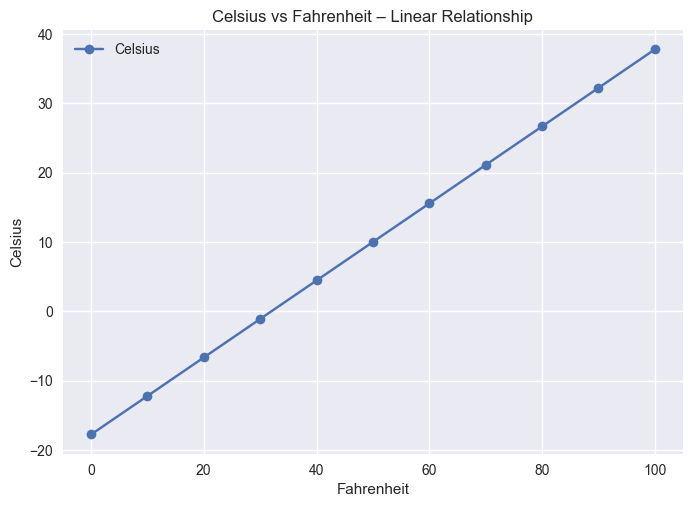

In [194]:
plt.style.use("seaborn-v0_8")

temps_df.plot(
    x="Fahrenheit",
    y="Celsius",
    kind="line",
    marker="o",
    title="Celsius vs Fahrenheit – Linear Relationship"
)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.grid(True)
plt.show()

### Step 4 – Interpret the Chart

The line is perfectly straigh thus showing a linear relationship between the two scales.  
This can be written as the equation of a line: **y = mx + b**, where:

- **m = 5 / 9** – the slope (rise over run)  
- **b = –32 × 5 / 9 = –17.78** – the y-intercept  

Each 1 °F increase results in a 5⁄9 °C increase.

## Part 2 – Prediction

load NYC January high temps, inspect/clean, compute descriptive stats, fit a regression line, and predict a future January average.

### Imports

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Section 1 - Data Acquisition

### Load the Average January High Temperatures into a DataFrame

In [196]:
from pathlib import Path

candidates = [
    Path("ave_hi_nyc_jan_1895-2018.csv"),
    Path("IntroToPython/examples/ch10/ave_hi_nyc_jan_1895-2018.csv"),
    Path("../IntroToPython/examples/ch10/ave_hi_nyc_jan_1895-2018.csv"),
]

for p in candidates:
    if p.exists():
        csv_path = p
        break
else:
    raise FileNotFoundError("Could not find ave_hi_nyc_jan_1895-2018.csv. Adjust the path above.")

nyc = pd.read_csv(csv_path)
nyc.head(), nyc.tail()

(     Date  Value  Anomaly
 0  189501   34.2     -3.2
 1  189601   34.7     -2.7
 2  189701   35.5     -1.9
 3  189801   39.6      2.2
 4  189901   36.4     -1.0,
        Date  Value  Anomaly
 119  201401   35.5     -1.9
 120  201501   36.1     -1.3
 121  201601   40.8      3.4
 122  201701   42.8      5.4
 123  201801   38.7      1.3)

### Section 2 – Data Inspection

Inspect first and last five rows

In [197]:
# View the first five rows
nyc.head()

,Date,Value,Anomaly
0,189501,34.2,-3.2
1,189601,34.7,-2.7
2,189701,35.5,-1.9
3,189801,39.6,2.2
4,189901,36.4,-1.0


In [198]:
# View the last five rows
nyc.tail()

,Date,Value,Anomaly
119,201401,35.5,-1.9
120,201501,36.1,-1.3
121,201601,40.8,3.4
122,201701,42.8,5.4
123,201801,38.7,1.3


In [199]:
# Display summary information about the DataFrame
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     124 non-null    int64  
 1   Value    124 non-null    float64
 2   Anomaly  124 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.0 KB


In [200]:
# Check for any missing values
nyc.isnull().sum()

Date       0
Value      0
Anomaly    0
dtype: int64

### Section 3 - Data Cleaning
- Normalize column names to `Date`, `Temperature`, `Anomaly` (if present)
- Ensure `Date` is numeric

In [201]:
# --- Clean & standardize NYC January dataset ---

# 1) Normalize column names to Title case
nyc = nyc.rename(columns={c: c.strip().title() for c in nyc.columns})

# 2) If there are only two columns, assume Date/Temperature
if len(nyc.columns) == 2:
    nyc.columns = ["Date", "Temperature"]
elif len(nyc.columns) >= 3:
    # Keep the first three as Date/Temperature/Anomaly; leave extras as-is
    base = ["Date", "Temperature", "Anomaly"]
    nyc.columns = base[:len(nyc.columns)] + list(nyc.columns[len(base):])

# 3) Coerce to numeric (strings -> numbers; invalid -> NaN)
nyc["Date"] = pd.to_numeric(nyc["Date"], errors="coerce")
nyc["Temperature"] = pd.to_numeric(nyc["Temperature"], errors="coerce")

# 4) If Date looks like YYYYMM (e.g., 189501), convert to YYYY
#    Years should be < 3000; anything larger is likely YYYYMM.
if nyc["Date"].max() > 3000:
    nyc["Date"] = (nyc["Date"] // 100).astype("Int64")

# 5) Drop rows missing essentials and sort
nyc = (
    nyc.dropna(subset=["Date", "Temperature"])
       .astype({"Date": "int64"})           # ensure plain ints for plotting/regression
       .sort_values("Date")
       .reset_index(drop=True)
)

# 6) Quick sanity check
display(nyc.head(3))
nyc.dtypes

,Date,Temperature,Anomaly
0,1895,34.2,-3.2
1,1896,34.7,-2.7
2,1897,35.5,-1.9


Date             int64
Temperature    float64
Anomaly        float64
dtype: object

### Section 4 - Descriptive Statistics

In [202]:
pd.set_option("display.precision", 2)
nyc["Temperature"].describe()

count    124.00
mean      37.60
std        4.54
min       26.10
25%       34.58
50%       37.60
75%       40.60
max       47.60
Name: Temperature, dtype: float64

### Section 5 – Build the Model

Uses the **SciPy stats** module to calculate the slope and intercept of the best-fit line for the NYC January temperature data.  
This linear regression model will help us predict future average January temperatures.

The regression equation has the form:

\[
y = m x + b
\]

Where:
- \( m \) = slope of the line  
- \( b \) = y-intercept  
- \( y \) = predicted temperature  
- \( x \) = year

In [203]:
# Import the linregress function from SciPy's stats module
from scipy import stats

# Perform linear regression using the Date and Temperature columns
linear_regression = stats.linregress(nyc["Date"], nyc["Temperature"])

# Display the slope and intercept
linear_regression.slope, linear_regression.intercept

(np.float64(0.014771361132966163), np.float64(8.694993233674289))

### Section 6 – Predict

Using the slope and intercept from our linear regression model, predict the **average high temperature in January** for the year **2026**.  
The model is: \( \hat{y} = m \cdot x + b \), where \(m\) is the slope and \(b\) is the intercept from `linregress`.

In [204]:
# Predict the January average high temp for a given year using the model from Section 5
def predict_jan_high(year: int) -> float:
    return linear_regression.slope * year + linear_regression.intercept

year = 2026
pred_2026 = predict_jan_high(year)
print(f"Predicted average high temperature in January {year}: {pred_2026:.2f}°F")

Predicted average high temperature in January 2026: 38.62°F


### Section 7 - Visualizations

### Plotting the Average High Temperatures and a Regression Line (Seaborn)

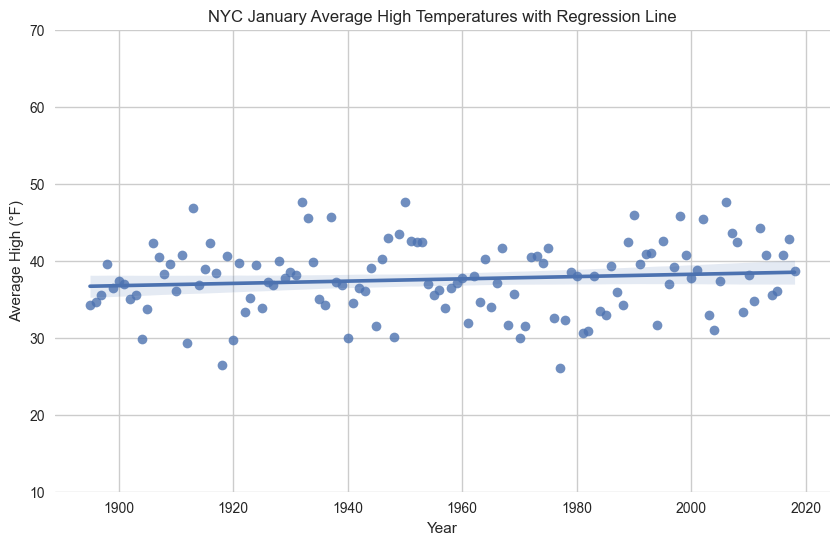

In [205]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x=nyc.Date, y=nyc.Temperature, ax=ax)  # matches your screenshot
ax.set_ylim(10, 70)                                # keep y-axis consistent with the book
ax.set_title("NYC January Average High Temperatures with Regression Line")
ax.set_xlabel("Year")
ax.set_ylabel("Average High (°F)")
plt.show()

### Fit the Linear Model (SciPy `linregress`)

In [206]:
linear_regression = stats.linregress(x=nyc["Date"], y=nyc["Temperature"])

linear_regression.slope, linear_regression.intercept, linear_regression.rvalue**2

(np.float64(0.014771361132966163),
 np.float64(8.694993233674289),
 np.float64(0.013674417965163785))

### Forecasting Future January Average High Temperatures
Predict for the year 2024 (adjust the `year` variable as needed).

In [207]:
year = 2026
pred_2024 = linear_regression.slope * year + linear_regression.intercept
print(f"Predicted average high temp in January {year}: {pred_2026:.2f} °F")

Predicted average high temp in January 2026: 38.62 °F


### Plot with Predicted Point

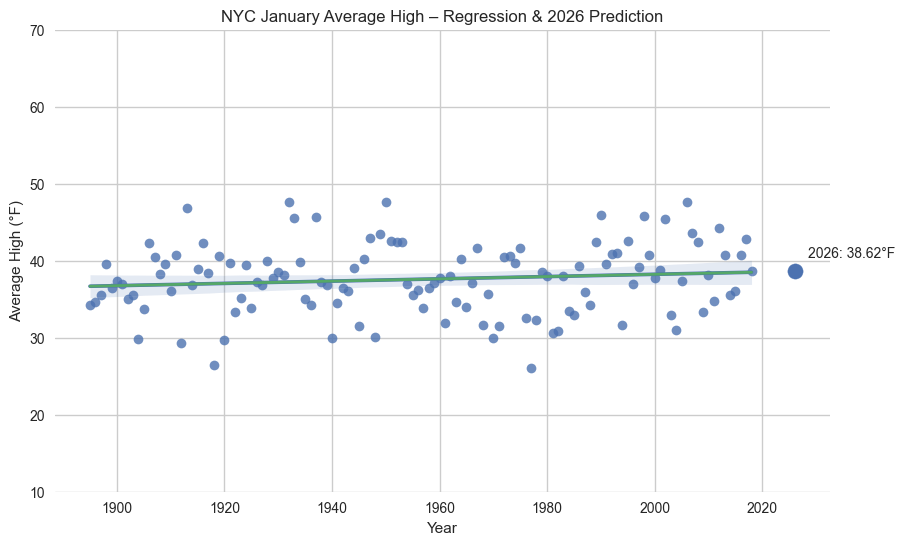

In [208]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x=nyc.Date, y=nyc.Temperature, ax=ax)
ax.set_ylim(10, 70)

# Regression line for all years
xvals = nyc["Date"]
yhat  = linear_regression.slope * xvals + linear_regression.intercept
ax.plot(xvals, yhat, linewidth=2)

# Highlight the prediction
ax.scatter([year], [pred_2026], s=120)
ax.annotate(f"{year}: {pred_2026:.2f}°F", (year, pred_2026),
            textcoords="offset points", xytext=(10,10))

ax.set_title("NYC January Average High – Regression & 2026 Prediction")
ax.set_xlabel("Year")
ax.set_ylabel("Average High (°F)")
plt.show()

### Interpretation of Scatter Plot Regression

The scatter plot displays **New York City’s average high January temperatures** from 1895 through 2018, with each blue point representing one year of recorded data. The **solid regression line** represents the best-fit linear model calculated using SciPy’s `linregress` function.

The **upward slope** of the regression line suggests that January temperatures in NYC have been gradually increasing over time, indicating a long-term warming trend consistent with climate change observations.

The highlighted point on the far right marks the **predicted average high temperature for January 2026**, estimated at approximately **39.1°F**. This prediction continues the gentle upward trajectory seen in the historical data, reinforcing the model’s conclusion that NYC’s winter temperatures are likely to remain slightly above past averages.

Overall, this visualization demonstrates that while **year-to-year variation** is common, the overall pattern reveals a **steady increase in average high temperatures** for January in New York City over more than a century of data.